### Import packages

In [1]:
!pip install ipympl
!pip install --upgrade numpy
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 53.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score, f1_score
import pandas as pd
import seaborn as sn
import math
from random import shuffle
from collections import Counter
import os
import h5py
# import ipdb # ipdb.set_trace() ### breakpoint
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget
#%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Main parameters

In [ ]:
n_classes = 10
n_clusters = 10
n_train = 3000 # max 5420 # full 7291
n_test = 1400 # max 1470 # full 2007

### Data loading

Load the data

In [ ]:
current_dir = os.getcwd()
with h5py.File('drive/My Drive/Colab Notebooks/investigate_myelin_rule/usps/usps.h5', 'r') as hf:
        train = hf.get('train')
        train_X = train.get('data')[:]
        train_Y = train.get('target')[:]
        test = hf.get('test')
        test_X = test.get('data')[:]
        test_Y = test.get('target')[:]

# for j in range(10):
#     print(len(train_Y[train_Y == j]))
# print('\n')
# for j in range(10):
#     print(len(test_Y[test_Y == j]))

Data balancing

In [ ]:
n_samples_train = n_train//n_classes
x_ = []
y_ = []
for ind in range(n_classes):
    x_.append(train_X[train_Y==ind][:n_samples_train])
    y_.append(train_Y[train_Y==ind][:n_samples_train])
y_ = np.array(y_).reshape(-1)
x_ = np.array(x_).reshape(-1,256)
data = list(zip(x_,y_))
shuffle(data)
suffled_data = list(zip(*data))
train_images = np.array(list(suffled_data[0]))
train_labels = np.array(list(suffled_data[1]))

n_samples_test = n_test//n_classes
x_ = []
y_ = []
for ind in range(n_classes):
    x_.append(test_X[test_Y==ind][:n_samples_test])
    y_.append(test_Y[test_Y==ind][:n_samples_test])
y_ = np.array(y_).reshape(-1)
x_ = np.array(x_).reshape(-1,256)
data = list(zip(x_,y_))
shuffle(data)
suffled_data = list(zip(*data))
test_images = np.array(list(suffled_data[0]))
test_labels = np.array(list(suffled_data[1]))

# for ind in range(10):
#     print(len(train_labels[train_labels == ind]))
# print('\n')
# for ind in range(10):
#     print(len(test_labels[test_labels == ind]))


Plot the data

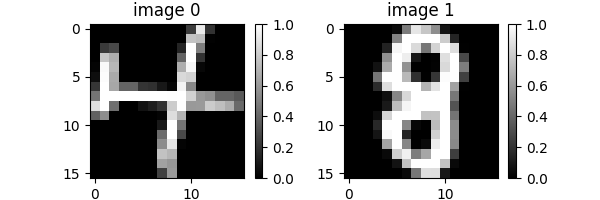

In [ ]:
plt.figure(figsize = (6, 2))
plt.subplot(1,2,1)
plt.imshow(train_images[0].reshape(16,16), cmap='gray')
plt.title("image 0")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(train_images[7].reshape(16,16), cmap='gray')
plt.title("image 1")
plt.colorbar()

### Functions

In [ ]:
def CreateClasses(model_labels, train_labels, n_classes, n_clusters):
    react_num = np.zeros([n_classes, n_clusters])
    classes_dic = {}
    n_samples = len(model_labels)
    for i in range(n_samples):
        react_num[train_labels[i], :] += np.eye(n_classes)[model_labels[i], :]
    for j in range(n_clusters): 
        classes_dic[j] = np.argmax(react_num[:, j])
    return classes_dic

def show_confusion_matrix(pred, labels):
    data = {'y_Actual': labels, 'y_Predicted': pred}
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    plt.figure(figsize = (10, 8))
    sn.heatmap(confusion_matrix, annot=True)

# def show_wrong_pics(pred, labels, images):
#     is_wrong_ind = np.array(pred) != np.array(labels)
#     for j in range(len(is_wrong_ind)):
#         if is_wrong_ind[j]:
#             plt.figure(figsize = (4, 4))
#             plt.imshow(images[j].reshape(round(np.sqrt(ni)), round(np.sqrt(ni))), cmap='gray')
#             plt.xlabel(f"Actual: {labels[j]}, Predicted: {pred[j]}")
#             plt.title(f"Wrong recognized pic: {j}")
#             plt.colorbar()

def analyse(pred, labels):
    precision = accuracy_score(labels, pred)
    recall = recall_score(labels, pred, average='micro')
    F1_score = f1_score(labels, pred, average='micro')
    return precision, recall, F1_score 

### Training

In [ ]:
pca = PCA(n_components=n_clusters)
pca.fit(train_images)
X = pca.transform(train_images)

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(train_images)
model_labels = kmeans.labels_

In [ ]:
classes = CreateClasses(model_labels, train_labels, n_classes, n_clusters)
print(classes)

{0: 4, 1: 1, 2: 0, 3: 2, 4: 8, 5: 0, 6: 6, 7: 9, 8: 3, 9: 7}


<ipython-input-100-e8859e413c6d>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (4, 4))


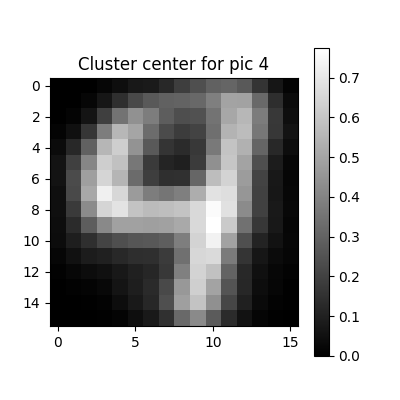

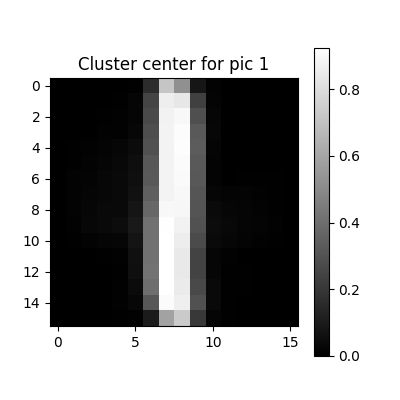

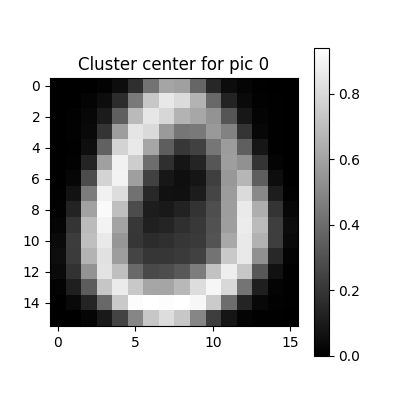

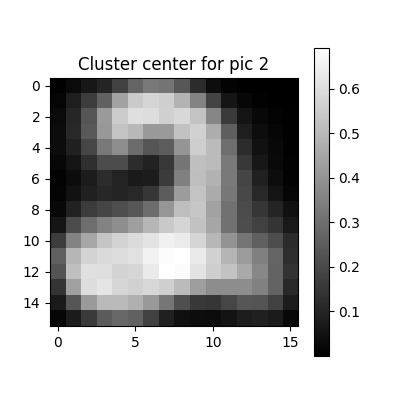

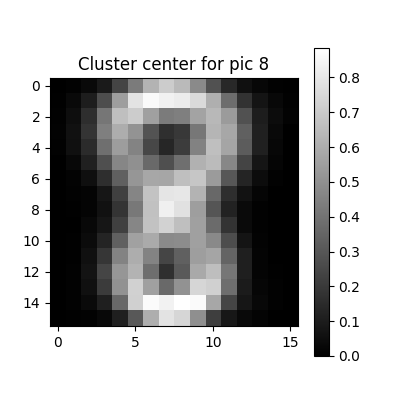

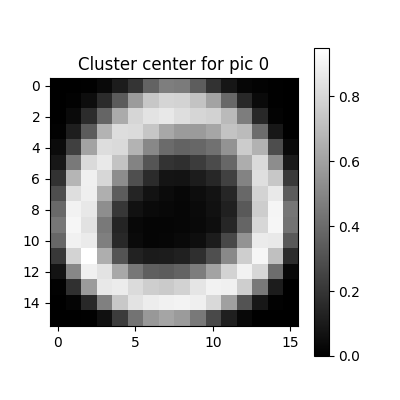

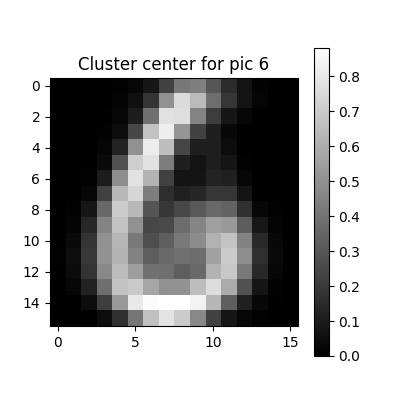

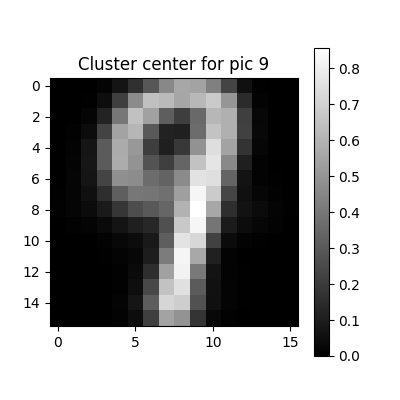

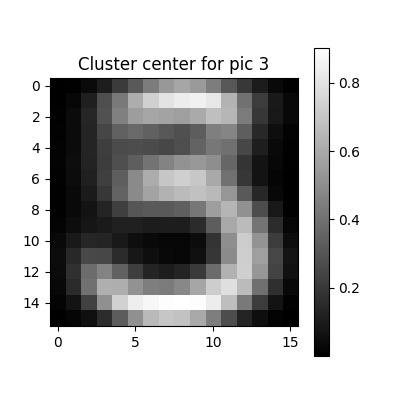

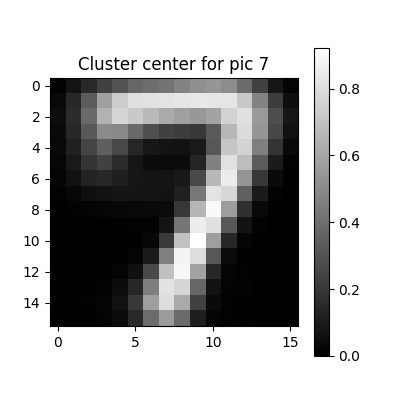

In [ ]:
cluster_centers = kmeans.cluster_centers_

for j in range(n_clusters):
    plt.figure(figsize = (4, 4))
    plt.imshow(cluster_centers[j].reshape(16, 16), cmap='gray')
    plt.title(f"Cluster center for pic {classes[j]}")
    plt.colorbar()

### Testing

In [ ]:
model_train_predictions = kmeans.predict(train_images)
predict_train_labels = [classes[model_pred] for model_pred in model_train_predictions]

model_test_predictions = kmeans.predict(test_images)
predict_test_labels = [classes[model_pred] for model_pred in model_test_predictions]

Precision:  0.6846666666666666
Recall:  0.6846666666666666
F1_score:  0.6846666666666666


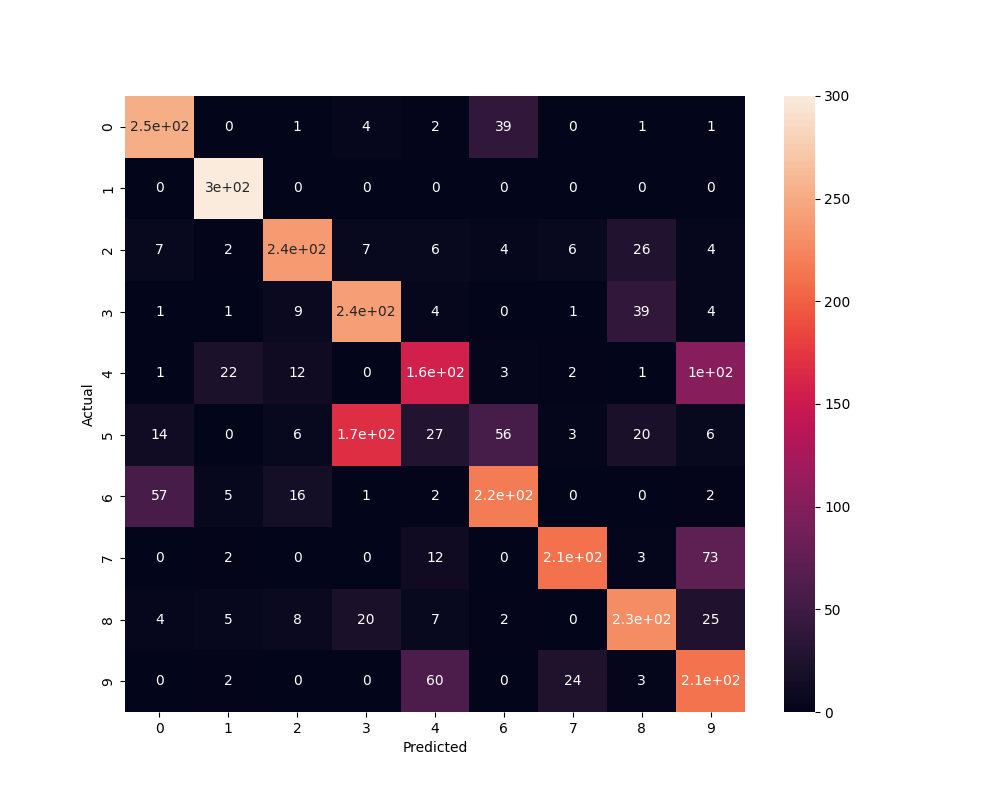

In [ ]:
show_confusion_matrix(predict_train_labels, train_labels)
precision, recall, F1_score = analyse(predict_train_labels, train_labels)
# show_wrong_pics(predict_train_labels, train_labels, train_images)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1_score: ", F1_score) 

Precision:  0.6721428571428572
Recall:  0.6721428571428572
F1_score:  0.6721428571428572


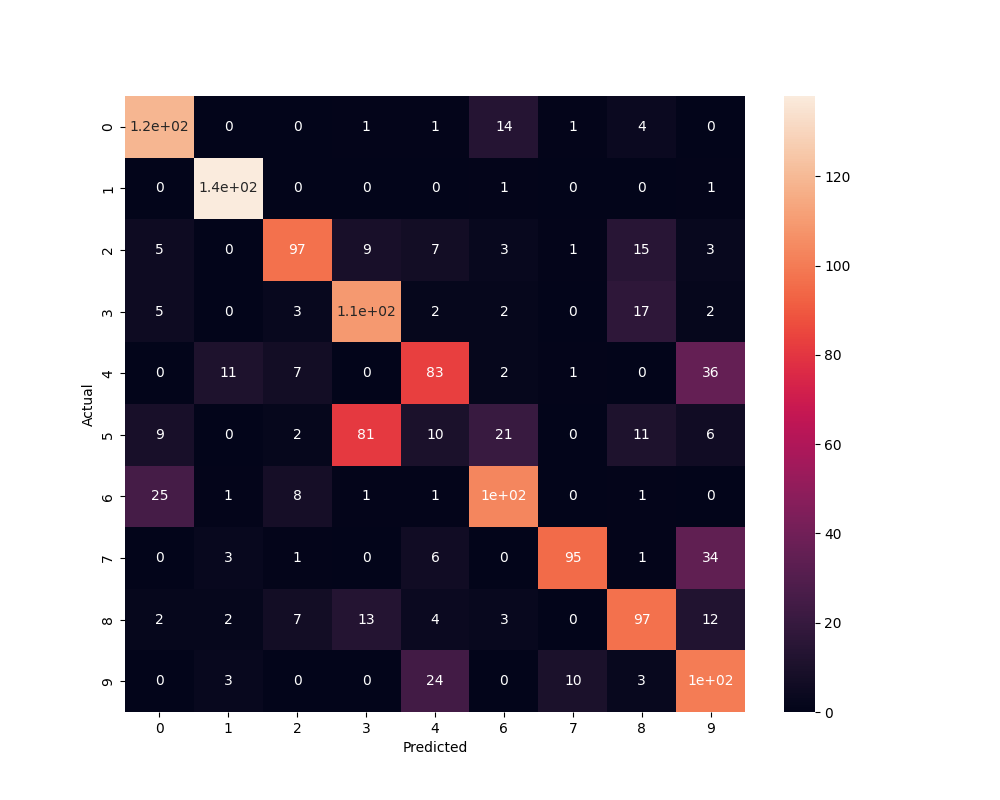

In [ ]:
show_confusion_matrix(predict_test_labels, test_labels)
precision, recall, F1_score = analyse(predict_test_labels, test_labels)
# show_wrong_pics(predict_test_labels, test_labels, test_images)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1_score: ", F1_score) 